In [1]:
import json
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import argparse
import os
import visualizer as VS
import eval_utils as EU
import numpy as np
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors
import sys

%reload_ext autoreload
%autoreload 2

In [2]:
embedding_storage = {
    "node2vec": '../node2vec/emb/',
    "ProNE": '../ProNE/emb/'
}

with open("../embedding_config.json", "r") as jsonfile:
    embeddding_config = json.load(jsonfile)
num_bins = embeddding_config["num_bins"]
test_size = embeddding_config["test_size"]

In [13]:
task = "genes"
method = "node2vec"

In [14]:
with open("../data/data_config.txt", "r") as jsonfile:
    data_config = json.load(jsonfile)
with open("../data/strategies/" + task + ".txt", "r") as jsonfile:
    strategies = json.load(jsonfile)
config = data_config[task]
location = config["location"]
target_file = config["target_file"]
location_processed = config["location_processed"]
target_column = config["target_column"]

In [15]:
# Load data
import os; print(os.getcwd())
print(os.path.join("../", location_processed))
trimmed_table = pd.read_csv(os.path.join("../", location_processed), sep=',', encoding='latin')
full_table = pd.read_csv(os.path.join("../", location + target_file), sep=',', encoding='latin')

Y = full_table[target_column]
if task in ["kraken", "financial", "genes"]:
    Y = pd.Categorical(Y).codes

# Set embeddings that are to be evaluated
all_embeddings_path = EU.all_files_in_path(embedding_storage[method], task)

/home/cc/Embedding/evaluation
.././data/genes/Classification.csv


In [16]:
path = all_embeddings_path[0]
path

'../node2vec/emb/genes.emb'

acy: 0.9191
Epoch 362/500
22/22 [==============================] - 0s 3ms/step - loss: 1.8238 - accuracy: 0.9927 - val_loss: 1.8943 - val_accuracy: 0.9191
Epoch 363/500
22/22 [==============================] - 0s 3ms/step - loss: 1.8238 - accuracy: 0.9927 - val_loss: 1.8942 - val_accuracy: 0.9191
Epoch 364/500
22/22 [==============================] - 0s 3ms/step - loss: 1.8238 - accuracy: 0.9927 - val_loss: 1.8941 - val_accuracy: 0.9191
Epoch 365/500
22/22 [==============================] - 0s 3ms/step - loss: 1.8238 - accuracy: 0.9927 - val_loss: 1.8941 - val_accuracy: 0.9191
Epoch 366/500
22/22 [==============================] - 0s 3ms/step - loss: 1.8237 - accuracy: 0.9927 - val_loss: 1.8940 - val_accuracy: 0.9191
Epoch 367/500
22/22 [==============================] - 0s 3ms/step - loss: 1.8237 - accuracy: 0.9927 - val_loss: 1.8940 - val_accuracy: 0.9191
Epoch 368/500
22/22 [==============================] - 0s 3ms/step - loss: 1.8237 - accuracy: 0.9927 - val_loss: 1.8940 - val_accu

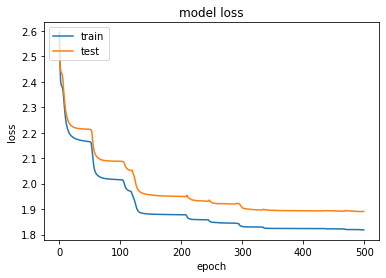

In [17]:
model = KeyedVectors.load_word2vec_format(path)
table_name = path.split("/")[-1][:-4]
if "_sparse" in table_name or "_spectral" in table_name:
    table_name = "_".join(table_name.split("_")[:-1])
model_dict_path = "../graph/{}/{}.dict".format(task, table_name)
        
print(model_dict_path)
# Obtain textified & quantized data
training_loss = []
testing_loss = []
for i in [100]:
    if i > model.vector_size: continue 
    df_textified = EU.textify_df(
        trimmed_table, strategies, location_processed)
    x_vec = EU.vectorize_df(
        df_textified, model, model.vocab,
        model_dict=model_dict_path, model_type=method
    )

    model_2dim = EU.get_PCA_for_embedding(model, ndim=i)
    x_vec_2dim = EU.vectorize_df(
        df_textified, model_2dim, model.vocab,
        model_dict=model_dict_path, model_type=method
    )
    tests = train_test_split(x_vec_2dim, Y, test_size=test_size, random_state=1234)
    train_loss, test_loss = EU.classification_task_nn(*tests)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)